# Anomaly detection using Autoencoder (Tensorflow)

## Dataset

To build an Autoencoder to detect anomalies on <a href='http://www.timeseriesclassification.com/description.php?Dataset=ECG5000'>ECG5000 dataset</a>. It contain 5,000 <a href='https://en.wikipedia.org/wiki/Electrocardiography'>Electrocardiograms</a>, each with 140 data points. 

<img src='https://th.bing.com/th/id/R.646b815fdd494ff5e209094eb3814437?rik=lTnVYdbamdL7uw&riu=http%3a%2f%2f1.bp.blogspot.com%2f-W34GZ4MEhFA%2fUFNl9_qxMoI%2fAAAAAAAAABk%2fUaP8dOKg49A%2fs1600%2fNormal_ECG.bmp&ehk=BRlKdADznwD9BvzZXoYgqusJ8Oh%2fEZcD8i%2fC%2bRE9EcM%3d&risl=&pid=ImgRaw&r=0' height='1000' margin_bottom='1000'>

<hr/>

## Autoencoder
- is an <b>unsupervised artificial neural network</b> that learns how to efficiently compress and encode data then learns how to <b>reconstruct the data</b> back from the reduced encoded representation to a representation that is as close to the original input as possible.

-  reduces data dimensions by learning how to <b>ignore the noise </b>in the data.

<img src='https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.24.37-AM.png' width='600'/>

#### Autoencoder consists 4 main parts:
<h5>1. Encoder</h5>

- learns how to reduce the input dimensions
- compress the input data into an encoded representation

<h5>2. Bottleneck</h5>

- contains the compressed representation of the input data
- lowest possible dimensions of the input data

<h5>3. Decoder</h5>

- model learns how to reconstruct the data
- representation to be as close to the original input as possible

<h5>4. Reconstruction Loss</h5>

- measures measure how well the decoder is performing
- Or, how close the output is to the original input

#### Autoencoder Use Cases:
<h5>I. Anomaly Detection</h5>

- One we reconstruct the data (without noise), we can input abnormal data (data out of shape/ irregularity). The abnormal reconstructed data will have high losses compare to original data, and thus, we can detect it (abnormaly data) by determine the loss.
- In this project, we will show the anomaly detection using Autoencoder.

<h5>II. Image Denoising:</h5>

<img src='https://miro.medium.com/max/1000/1*sHOPK4Mm5kl5-fju9kLByg.png'/>

- Process of removing noise from a signal.
- This can be an image, audio or a document

<hr/>

<a id="0"></a>
## Table of Contents

1. [Import Libraries](#1)
2. [Import ECG dataset](#2)
3. [Take a glance of ECG graph](#3)
4. [Data Preprocessing](#4)
5. [Create Autoencoder model](#5)
6. [Anomalies Reconstruct and Detection (Find Thershold)](#6)
7. [Accuracy, Precision, Recall, F1 Score and Confusion Matrix](#7)

<a id="1"></a>
## 1. Import Libraries

[back to top](#0)

In [151]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

<a id="2"></a>
## 2. Import ECG dataset

[back to top](#0)

In [181]:
data = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

df = pd.read_csv(data, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [170]:
print(f'Data Shape: {df.shape}')

Data Shape: (4998, 141)


<a id="3"></a>
## 3. Take a glance of ECG graph

[back to top](#0)

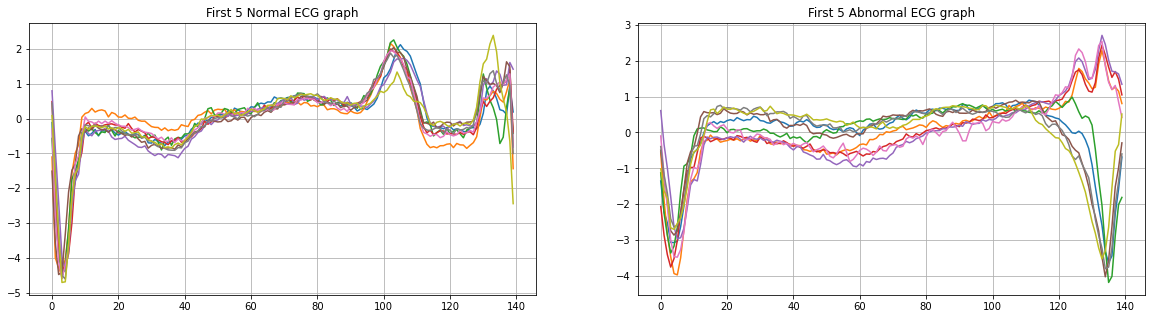

In [199]:
plt.figure(figsize=(20,5))

plt.subplot(121)
for i in range(9):
    df.iloc[i,:-1].plot(grid=True)
plt.title('First 5 Normal ECG graph')

plt.subplot(122)
for i in range(9):
    df.iloc[-i-1,:-1].plot(grid=True)
plt.title('First 5 Abnormal ECG graph')

plt.show()

- From diagram above, we can observe that normal ECGs data are more <b>consistence</b> compare to Abnormal EGCs data

<a id="4"></a>
## 4. Data Preprocessing
- is a step in the data mining and data analysis process that takes raw data and transforms it into a format that can be understood and analyzed by computers and machine learning.

[back to top](#0)

### - Train test split
- is a technique for evaluating the performance of a machine learning algorithm.

In [200]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

###  - Scale data
- Scale the data to range 0 and 1

In [5]:
maxi = X_train.max(axis=0)
mini = X_train.min(axis=0)

train_X = (X_train - mini) / (maxi - mini)
valid_X = (X_valid - mini) / (maxi - mini)

In [6]:
# casting to tensor
train_X = tf.cast(train_X, tf.float32)
valid_X = tf.cast(valid_X, tf.float32)

### - Seperate into <b>Normal ECG</b> and <b>Abnormal ECG</b> data <br/>
1: Normal <br/>
0: Abnormal

In [12]:
normal_X_train = train_X[y_train == 1]
normal_X_valid = valid_X[y_valid == 1]

anamalous_X_train = train_X[y_train == 0]
anamalous_X_valid = valid_X[y_valid == 0]

### - Plot scaled ECG data

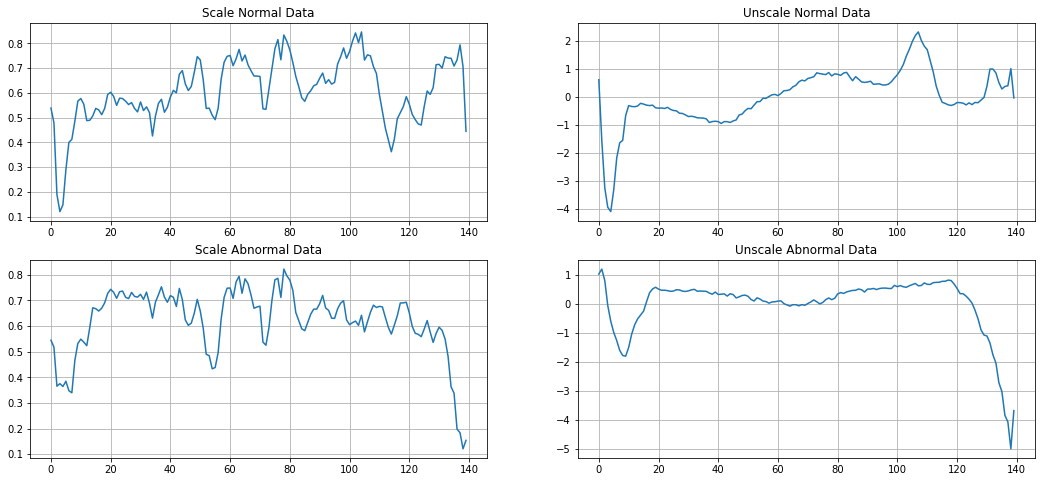

In [209]:
plt.figure(figsize=(18, 8))

plt.subplot(221)
plt.grid()
plt.plot(normal_X_train[0])
plt.title('Scale Normal Data')

plt.subplot(222)
plt.grid()
plt.plot(X_train[y_train == 1][0])
plt.title('Unscale Normal Data')

plt.subplot(223)
plt.grid()
plt.plot(anamalous_X_train[-1])
plt.title('Scale Abnormal Data')

plt.subplot(224)
plt.grid()
plt.plot(X_train[y_train == 0][-1])
plt.title('Unscale Abnormal Data')

plt.show()

<a id="5"></a>
## 5. Create Autoencoder model
- Autoencoder model using Tensorflow

[back to top](#0)

In [14]:
class AnomalyDetector(Model):
    def __init__(self):
        super().__init__()
        # encoder layer
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
        ])
        
        # decoder layer
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(x)
        return decoded
    
autoencoder = AnomalyDetector()

### - Parameter set-up

In [213]:
autoencoder.compile(optimizer='adam', loss='mse')

### - Model Training

In [211]:
history = autoencoder.fit(normal_X_train, normal_X_train, 
           epochs=20,
           batch_size=512,
           validation_data = (normal_X_valid, normal_X_valid),
           shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 34ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 11/20
5/5 [=====================

### - Plot Training and Validation loss

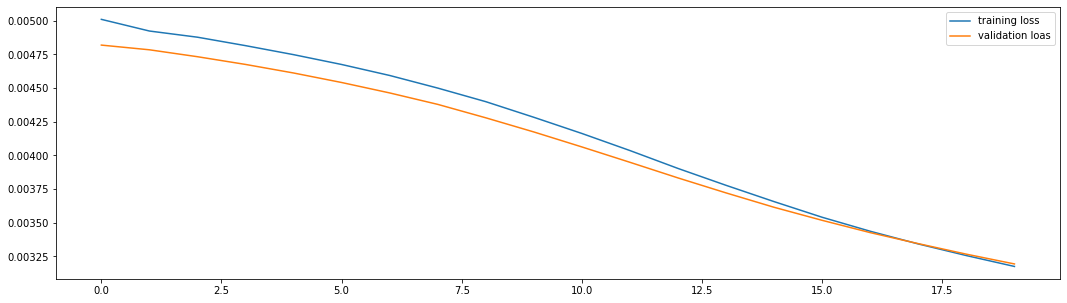

In [212]:
plt.figure(figsize=(18,5))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loas')
plt.legend() 
plt.show()

-  The lower the better. A good model should show down trend over epochs

<a id ="6"></a>

## 6. Anomalies Reconstruct and Detection

[back to top](#0)

### -  A normal ECG reconstruct plot

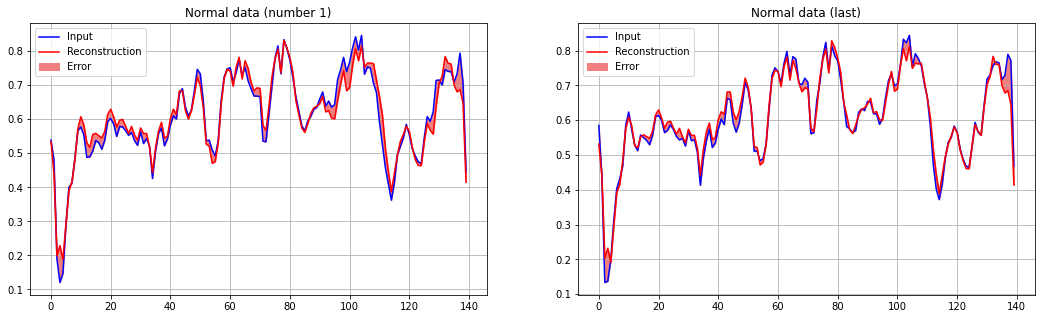

In [162]:
data_0 = autoencoder.predict(normal_X_train)

plt.figure(figsize=(18,5))

plt.subplot(121)
plt.grid()
plt.plot(normal_X_train[0], 'b')
plt.plot(data_0[0], 'r')
plt.fill_between(np.arange(140), normal_X_train[0], data_0[0], color='lightcoral' )
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.title('Normal data (number 1)')

plt.subplot(122)
plt.grid()
plt.plot(normal_X_train[-1], 'b')
plt.plot(data_0[-1], 'r')
plt.fill_between(np.arange(140), normal_X_train[-1], data_0[-1], color='lightcoral' )
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.title('Normal data (last)')

plt.show()

In [155]:
mse = losses.mse(normal_X_train[0], data_0[0])
mse_sec = losses.mse(normal_X_train[-1], data_0[-1])

print(f'MSE error data[0]: {mse:.6f}')
print(f'MSE error data[-1]: {mse_sec:.6f}')

MSE error data[0]: 0.000934
MSE error data[-1]: 0.000611


- Normal ECG has <b>less</b> error margin


### - An Abnormal ECG reconstruct plot

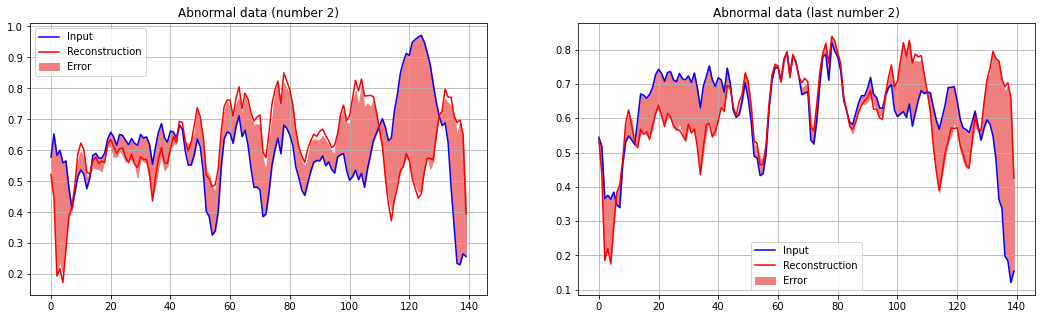

In [161]:
data_ab_0 = autoencoder.predict(anamalous_X_train)

plt.figure(figsize=(18,5))

plt.subplot(121)
plt.grid()
plt.plot(anamalous_X_train[0], 'b')
plt.plot(data_ab_0[1], 'r')
plt.fill_between(np.arange(140), anamalous_X_train[0], data_ab_0[0], color='lightcoral' )
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.title('Abnormal data (number 2)')

plt.subplot(122)
plt.grid()
plt.plot(anamalous_X_train[-1], 'b')
plt.plot(data_ab_0[-2], 'r')
plt.fill_between(np.arange(140), anamalous_X_train[-1], data_ab_0[-1], color='lightcoral' )
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.title('Abnormal data (last number 2)')


plt.show()

In [163]:
mse_ab = losses.mse(anamalous_X_train[0], data_ab_0[0])
mse_sec_ab = losses.mse(anamalous_X_train[-1], data_ab_0[-1])

print(f'MSE error data[0]: {mse_ab:.6f}')
print(f'MSE error data[-1]: {mse_sec_ab:.6f}')

MSE error data[0]: 0.034069
MSE error data[-1]: 0.017821


- Abnormal ECG has <b>high</b> error margin


### - Find Thershold
- determine normal and abnormal data thershold



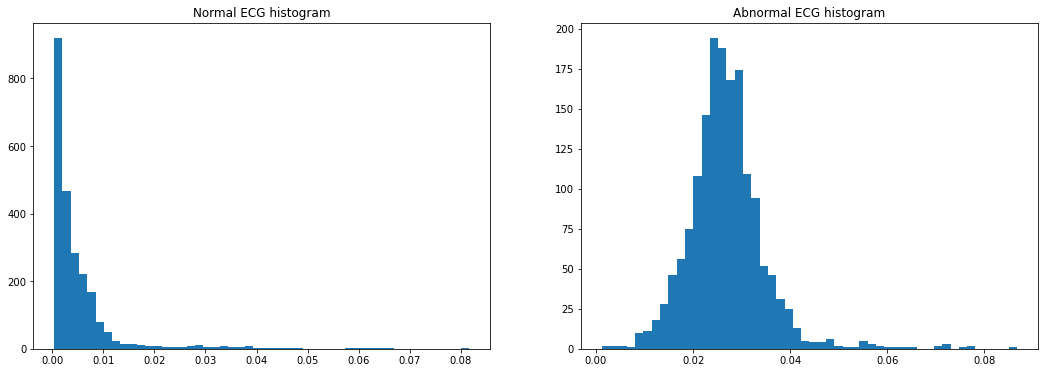

In [164]:
reconstruction_train_data = autoencoder.predict(normal_X_train)
train_loss = losses.mse(reconstruction_train_data, normal_X_train)

reconstruction_ab_train_data = autoencoder.predict(anamalous_X_train)
train_ab_loss = losses.mse(reconstruction_ab_train_data, anamalous_X_train)

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(train_loss.numpy(), bins=50)
plt.title('Normal ECG histogram')

plt.subplot(122)
plt.hist(train_ab_loss.numpy(), bins=50)
plt.title('Abnormal ECG histogram')

plt.show()

In [165]:
# threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print(f'Threshold: {threshold:.6f}')

Threshold: 0.012371


- Loss with lower than <b> threshold: 0.012371 </b>will consider as <b>Normal ECG</b>, beyond that will consider as <b> Abnormal ECG </b>

<a id="7"></a>
## 7. Accuracy, Precision, Recall, F1 Score and Confusion Matrix

<img src='https://i.pinimg.com/originals/be/7e/c5/be7ec54e78eb72a9e2a03590129df024.jpg' />
- <b>Note:</b> Recall is also known as sensitivity

[back to top](#0)

In [167]:
reconstruction_valid_data = autoencoder(valid_X)
loss_valid = losses.mse(reconstruction_valid_data, valid_X)
pred = [1 if i < threshold else 0 for i in loss_valid]

print("Accuracy = {:.2f}%".format(accuracy_score(pred, y_valid)*100))
print("Precision = {:.2f}%".format(precision_score(pred, y_valid)*100))
print("Recall = {:.2f}%".format(recall_score(pred, y_valid)*100))
print("F1 Score = {:.2f}%".format(f1_score(pred, y_valid)*100))

Accuracy = 95.00%
Precision = 93.29%
Recall = 97.78%
F1 Score = 95.48%


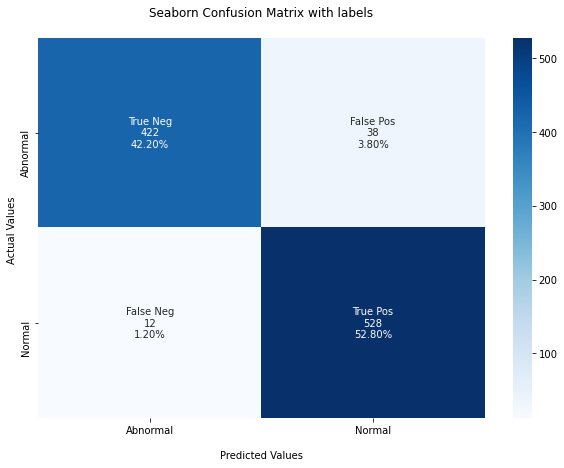

In [146]:
cm = confusion_matrix(pred, y_valid)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,7))
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])
ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
